In [46]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [100]:
EPOCHS = 15
BATCH_SIZE = 64
OUT = 10

#### Models

In [4]:
def single_layer_softmax_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
#         out -> 10, init -> N(0, 1)
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer= tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
                              activation = 'softmax', 
                              input_shape = (784,))
    ])
    
    model.compile(
        # Adam, crossentropy
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()],
    )
    
    return model

In [76]:
def multi_layer_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation="relu", input_shape=(array_size,)),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", tf.keras.metrics.AUC()]
    )
    
    return model

In [6]:
def only_tanh_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation="tanh", input_shape=(array_size,), kernel_initializer=tf.keras.initializers.GlorotNormal()),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

In [7]:
def only_relu_model(learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation="relu", input_shape=(array_size,), kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

#### Ploting

In [8]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

#### Fitting learning rate

No nessesity if using learning rate decay method, where the values of the $\alpha$ throught the epoch decreased by formula.

In [9]:
def fit_learning_rate(model_function, l, train_data, model_name):
    (X_train, y_train) = train_data
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

In [34]:
def model_with_checkpoints(learning_rate, training_set):
    (X_data, y_data) = training_set
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(OUT, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), activation="softmax", input_shape=(array_size,))
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    checkpoints = tf.keras.callbacks.ModelCheckpoint(
        "model.h5",
        monitor= "loss",
        verbose=True, 
        save_best_only=True
    )
    
    result = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=64,
        validation_split=0.2,
        verbose=2,
        callbacks = [checkpoints]
    )

#### Make generic activation method

In [55]:
def build_generic_activation(activation_method, learning_rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation=activation_method, input_shape=(array_size,)),
        tf.keras.layers.Dense(256, activation=activation_method),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ["accuracy", tf.keras.metrics.AUC()]
    )
    
    return model

In [58]:
def model_count_time(model, train_set, test_set):
    (X_train, y_train) = train_set
    (X_test, y_test) = test_set
    
    prediciton_time = 0
    
    start = time.time()
    result = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=False
    )
    end = time.time()
    
    learning_time = end - start
    train_accuracy = np.round(100 * result.history["accuracy"][-1], 3)
    
    start = time.time()
    _, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
    end = time.time()
    prediction_time = end - start
    test_accuracy = np.round(100 * accuracy, 3)
    
    print(f"Learning time: {learning_time}")
    print(f"Prediction time: {prediction_time}")
    print(f"Train accuracy: {train_accuracy}%, test accuracy {test_accuracy}%")

# MNIST

In [170]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"Shapes train set: X {X_train.shape} - y {y_train.shape}")
print(f"Shapes test set:  X {X_test.shape} - y {y_test.shape}")

m = X_train.shape

Shapes train set: X (60000, 28, 28) - y (60000,)
Shapes test set:  X (10000, 28, 28) - y (10000,)


This is number 2


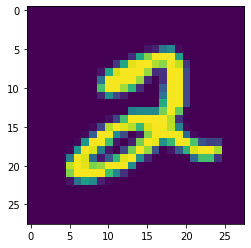

In [171]:
# Check for data
sample_num = 5
print(f"This is number {y_train[sample_num]}")

plt.imshow(X_train[sample_num])
plt.show()

In [183]:
array_size = X_train.shape[1] * X_train.shape[2]

# Flattening
X_train = X_train.reshape(X_train.shape[0], array_size).astype("float32")
X_test = X_test.reshape(X_test.shape[0], array_size).astype("float32")

X_train /= 255.0
X_test /= 255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [184]:
X_train.shape

(60000, 784)

In [185]:
model = single_layer_softmax_model()
result = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=False
)

SOFTMAX
On TEST accuracy: 0.9010000228881836, auc: 0.9847442507743835
AUC on TEST: 0.9847442507743835
Accuracy: 90.006% 



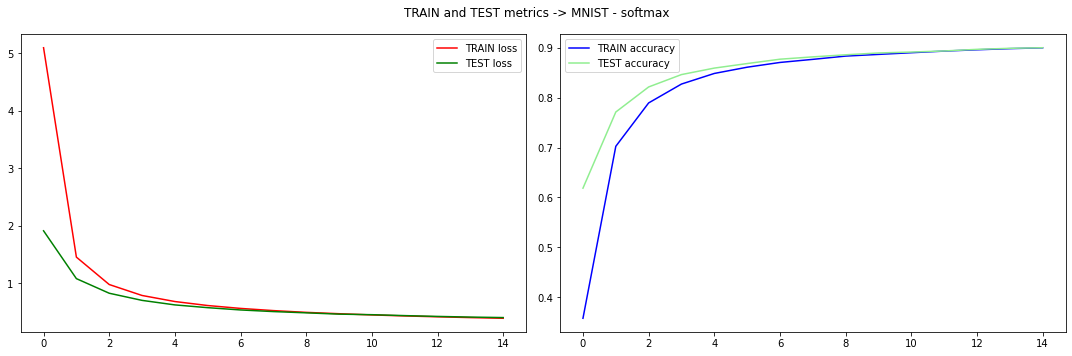

In [186]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print("SOFTMAX")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "MNIST - softmax")

In [77]:
model = multi_layer_model()
result = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    verbose=False
)

MULTILAYER
On TEST accuracy: 0.9035000205039978, auc: 0.9918489456176758
AUC on TEST: 0.9918489456176758
Accuracy: 89.65% 



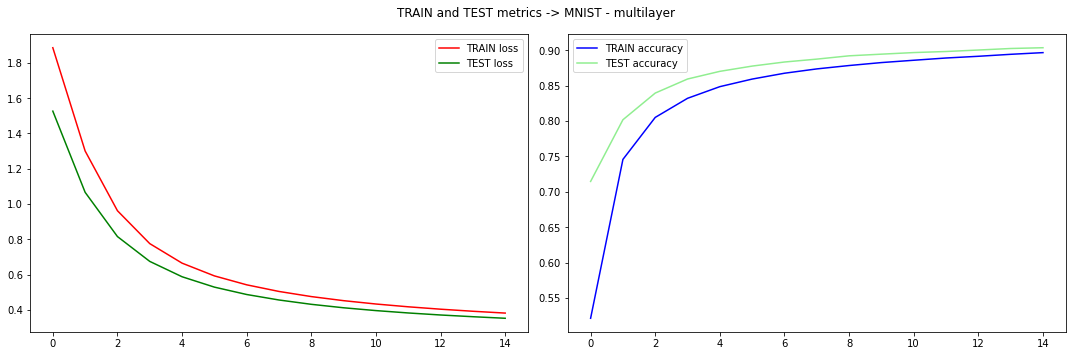

In [78]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print("MULTILAYER")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "MNIST - multilayer")

learning rate -> 0.1
Accuracy: 99.929% 



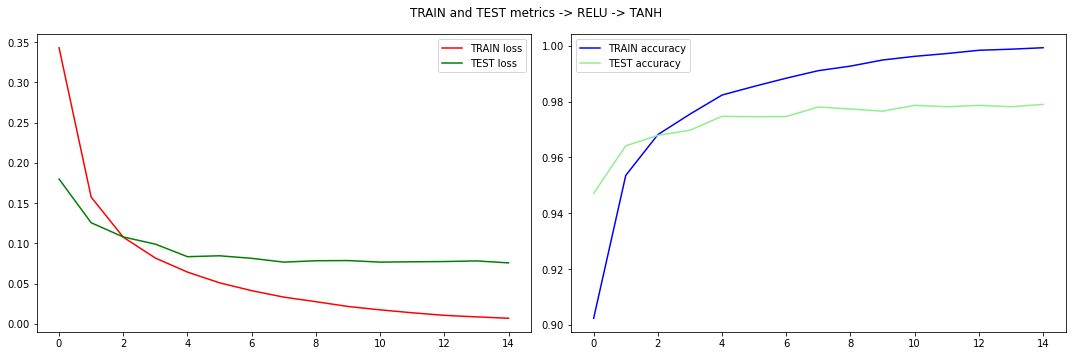

learning rate -> 0.01
Accuracy: 96.077% 



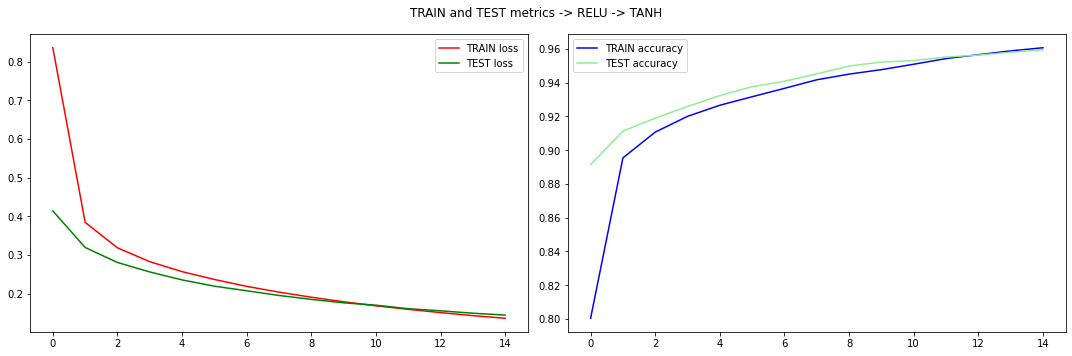

learning rate -> 0.001
Accuracy: 89.465% 



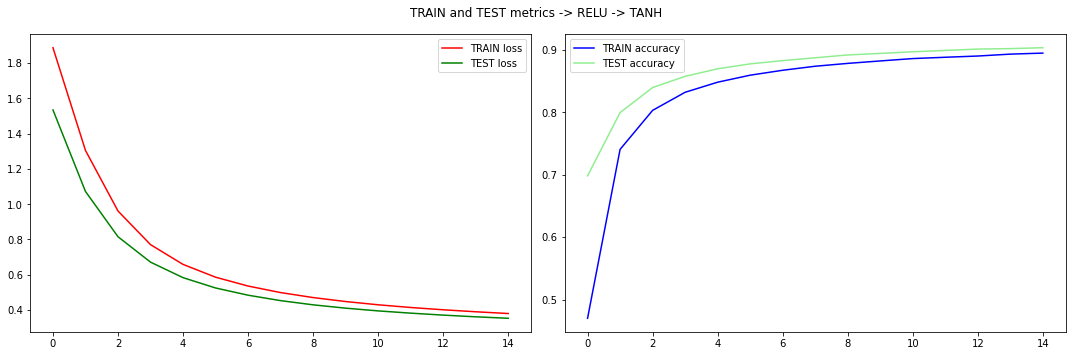

learning rate -> 0.0001
Accuracy: 74.733% 



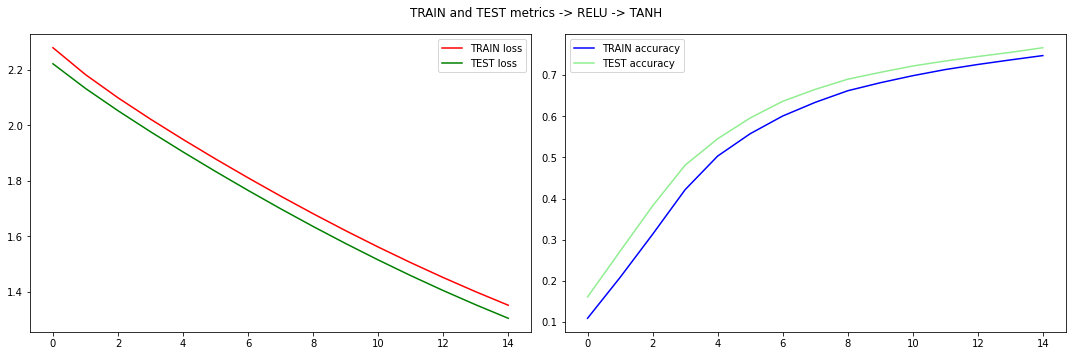

learning rate -> 1e-05
Accuracy: 13.156% 



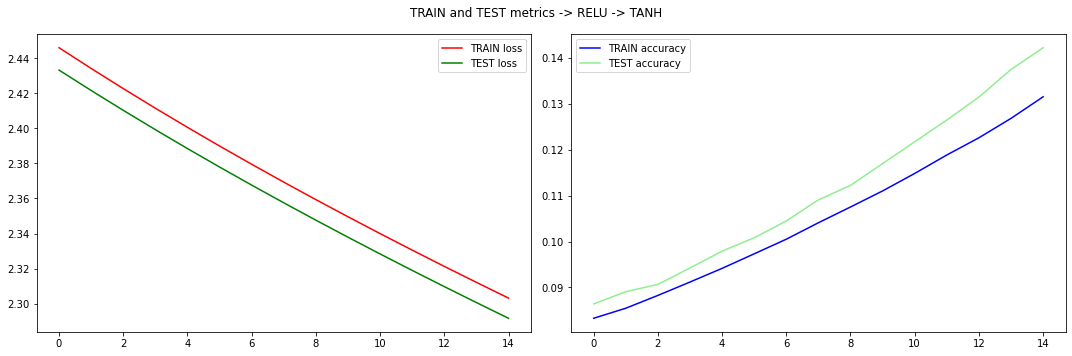

In [79]:
fit_learning_rate(multi_layer_model, 5, (X_train, y_train), "RELU -> TANH")

In [23]:
model = only_tanh_model()
result = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=False
)

TANH
On TEST accuracy: 0.9042999744415283, auc: 0.9915903210639954
AUC on TEST: 0.9915903210639954
Accuracy: 89.583% 



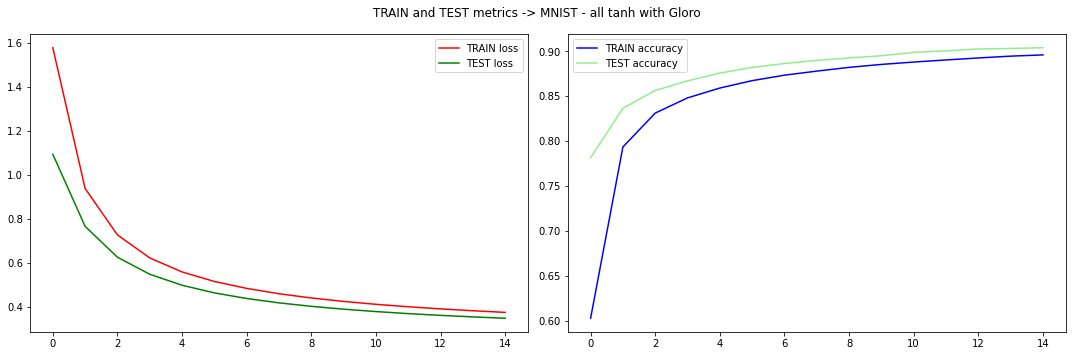

In [24]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print("TANH")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "MNIST - all tanh with Gloro")

learning rate -> 0.1
Accuracy: 99.437% 



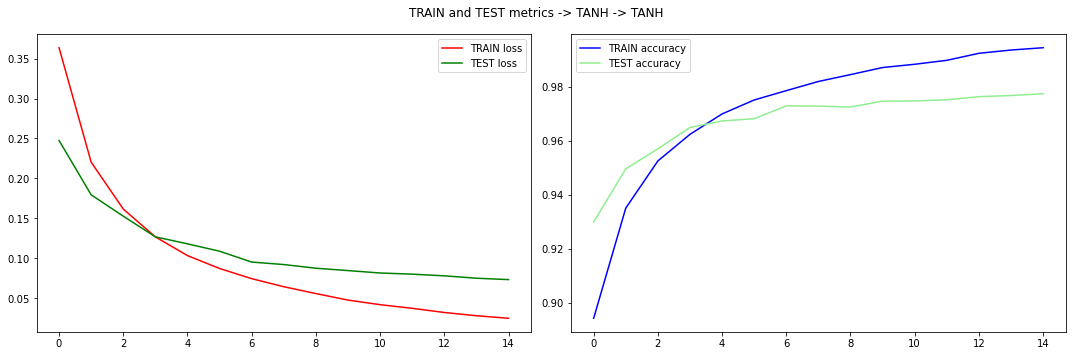

learning rate -> 0.01
Accuracy: 94.554% 



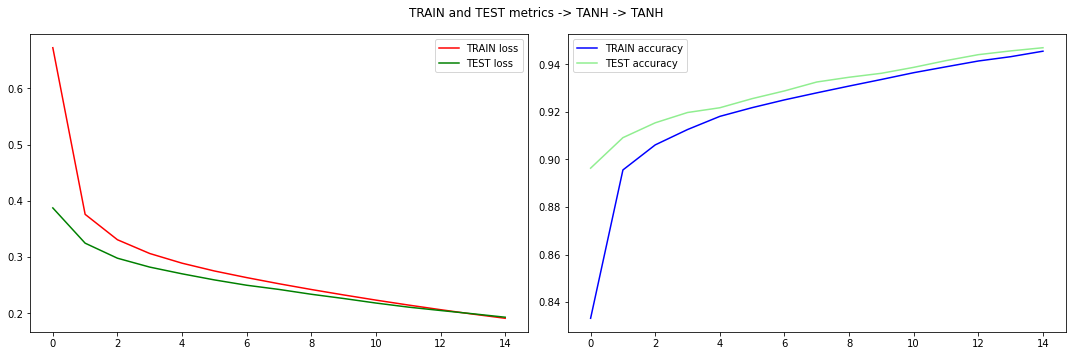

learning rate -> 0.001
Accuracy: 89.423% 



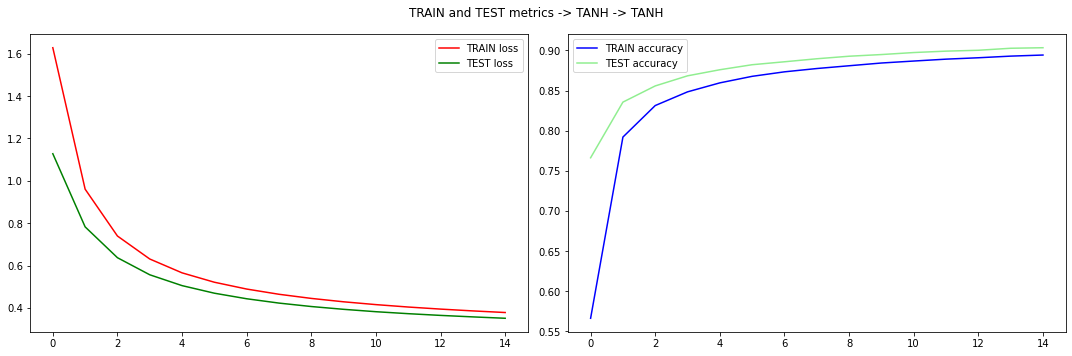

learning rate -> 0.0001
Accuracy: 79.433% 



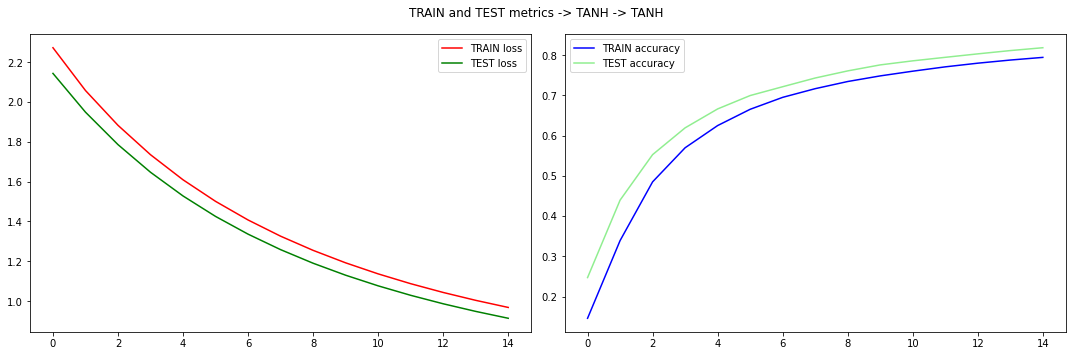

learning rate -> 1e-05
Accuracy: 30.915% 



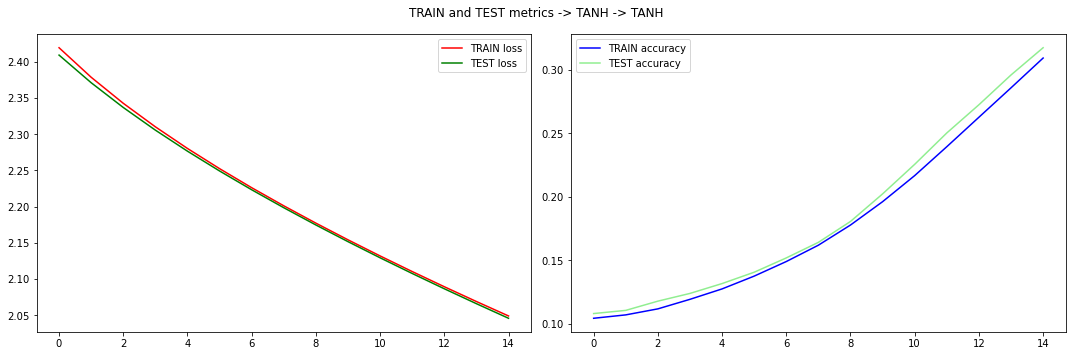

In [25]:
fit_learning_rate(only_tanh_model, 5, (X_train, y_train), "TANH -> TANH")

In [26]:
model = only_relu_model()
result = model.fit(
    X_train,
    y_train, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=False
)

Only RELU
On TEST accuracy: 0.906000018119812, auc: 0.9923698306083679
AUC on TEST: 0.9923698306083679
Accuracy: 89.975% 



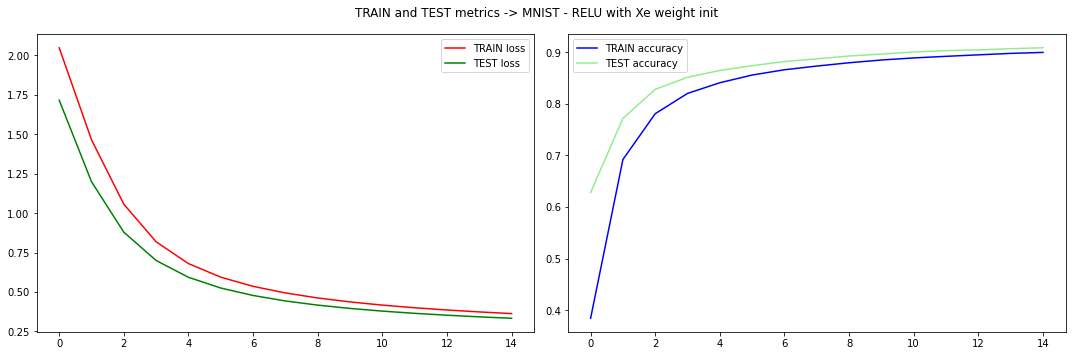

In [27]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print("Only RELU")
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "MNIST - RELU with Xe weight init")

learning rate -> 0.1
Accuracy: 99.96% 



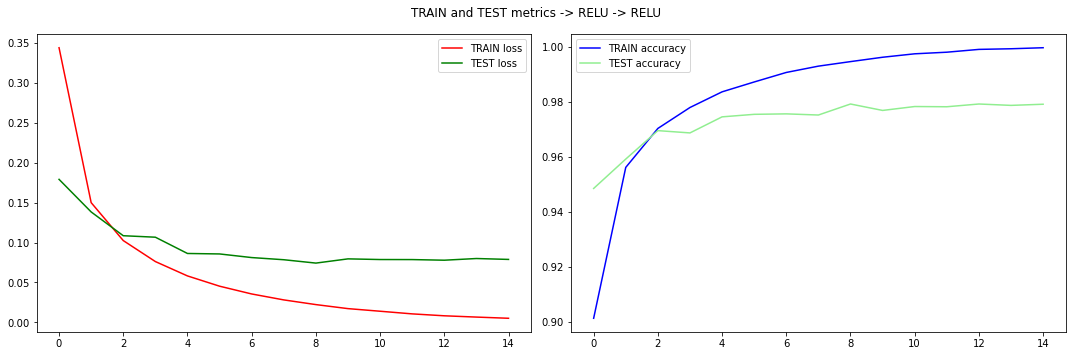

learning rate -> 0.01
Accuracy: 96.392% 



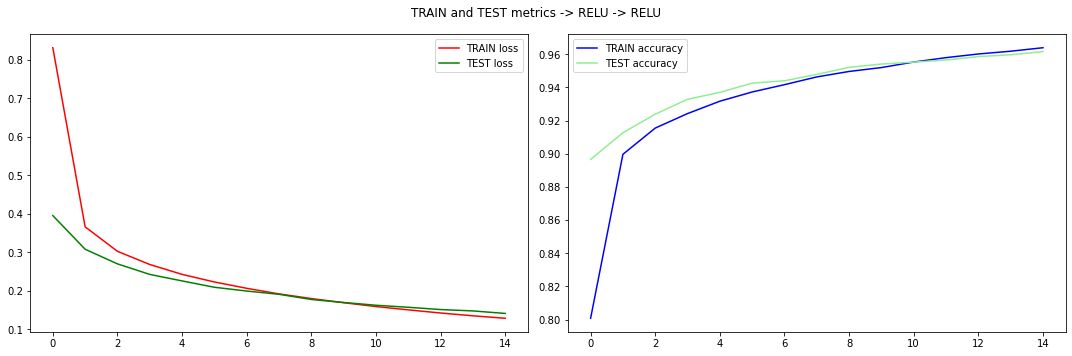

learning rate -> 0.001
Accuracy: 90.125% 



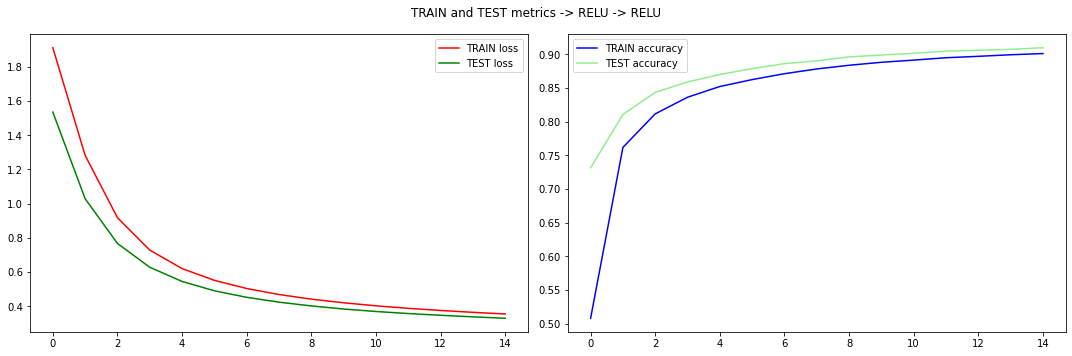

learning rate -> 0.0001
Accuracy: 73.21% 



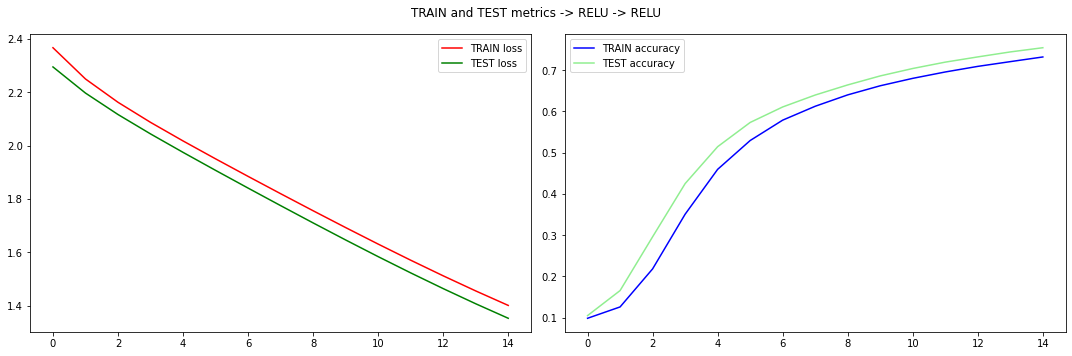

learning rate -> 1e-05
Accuracy: 14.381% 



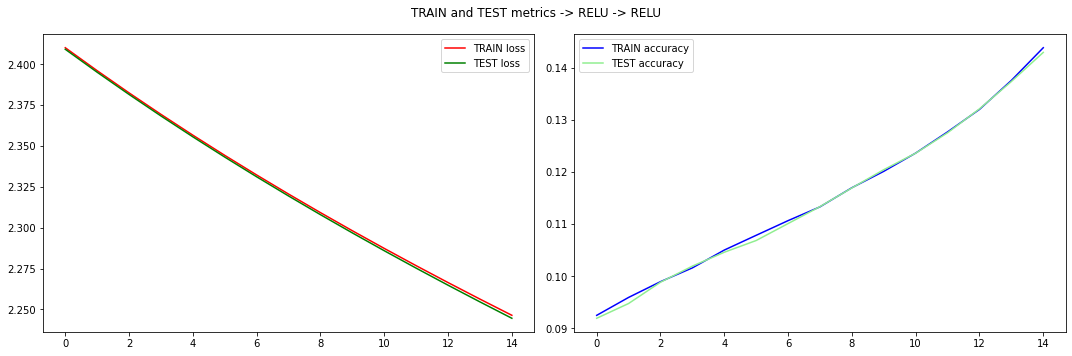

In [28]:
fit_learning_rate(only_relu_model, 5, (X_train, y_train), "RELU -> RELU")

#### Conclusion about MNIST:
- The worst accuracy metrics value when using traditional method
- Retraining the model is absent because of approximate match of two sets: TRAIN and TEST

#### Saving controll points

In [35]:
model_with_checkpoints(learning_rate=0.001, training_set=(X_train, y_train))

Epoch 1/15

Epoch 00001: loss improved from inf to 4.46351, saving model to model.h5
750/750 - 1s - loss: 4.4635 - accuracy: 0.4223 - auc_20: 0.7605 - val_loss: 1.6300 - val_accuracy: 0.6746 - val_auc_20: 0.9118 - 969ms/epoch - 1ms/step
Epoch 2/15

Epoch 00002: loss improved from 4.46351 to 1.37220, saving model to model.h5
750/750 - 1s - loss: 1.3722 - accuracy: 0.7218 - auc_20: 0.9293 - val_loss: 0.9875 - val_accuracy: 0.7888 - val_auc_20: 0.9534 - 552ms/epoch - 736us/step
Epoch 3/15

Epoch 00003: loss improved from 1.37220 to 0.96036, saving model to model.h5
750/750 - 1s - loss: 0.9604 - accuracy: 0.7933 - auc_20: 0.9551 - val_loss: 0.7732 - val_accuracy: 0.8346 - val_auc_20: 0.9658 - 550ms/epoch - 734us/step
Epoch 4/15

Epoch 00004: loss improved from 0.96036 to 0.78004, saving model to model.h5
750/750 - 1s - loss: 0.7800 - accuracy: 0.8265 - auc_20: 0.9656 - val_loss: 0.6628 - val_accuracy: 0.8530 - val_auc_20: 0.9721 - 574ms/epoch - 766us/step
Epoch 5/15

Epoch 00005: loss impr

label:  1


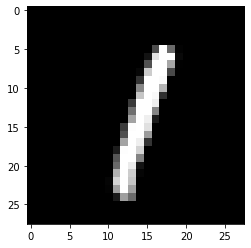

In [42]:
sample_num = 5 # what we are predicting

print('label: ', np.where(y_test[sample_num] == 1)[0][0])
image = X_test[sample_num].reshape(28, 28)

plt.imshow(image, cmap = 'gray')
plt.show()

In [43]:
loaded_model = tf.keras.models.load_model("model.h5", compile=True)
prediction = loaded_model.predict(X_test)
print(f"Predicted label value: {np.where(np.round(prediction[sample_num]) == 1)[0][0]}")

Predicted label value: 1


#### Activation method functions: LeakyReLU, Parametrics LeakyReLU, ELU
Description of: 
- train time
- network quality on test
- prediction time

- LeakyReLU 
- Parametric LeakyReLU 
- ELU
Learning time: 29.044695138931274
Prediction time: 0.3583202362060547
Train accuracy: 99.673%, test accuracy 97.99%
On TEST accuracy: 0.9812999963760376, auc: 0.9947338700294495
AUC on TEST: 0.9947338700294495
Accuracy: 99.819% 



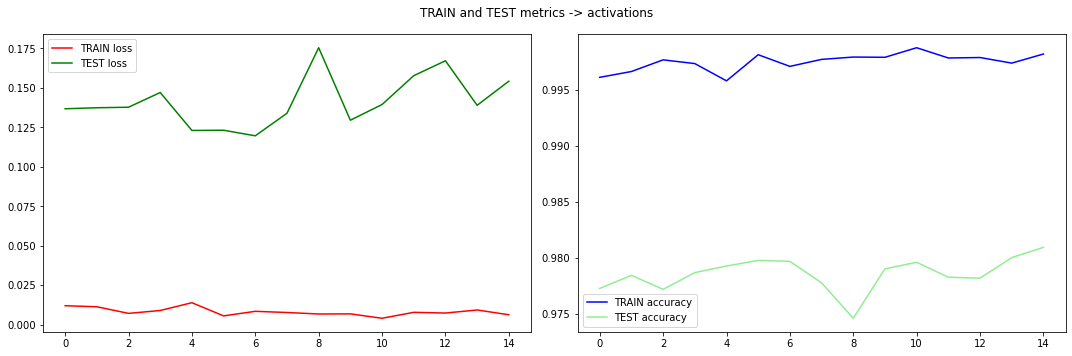

Learning time: 31.730875968933105
Prediction time: 0.33312249183654785
Train accuracy: 99.542%, test accuracy 98.0%


KeyboardInterrupt: 

In [136]:
learning_rate = 0.001
param = 0.1

activations = [
    tf.keras.layers.LeakyReLU(alpha=learning_rate),
    tf.keras.layers.LeakyReLU(alpha=param),
    tf.keras.activations.elu,
]
print("- LeakyReLU \n- Parametric LeakyReLU \n- ELU")
for activation in activations:
    model = build_generic_activation(activation, learning_rate)
    model_count_time(model, (X_train, y_train), (X_test, y_test))
    
    result = model.fit(
        X_train,
        y_train, 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=False
    )
    
    _, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
    print(f"On TEST accuracy: {accuracy}, auc: {auc}")
    print(f"AUC on TEST: {auc}")

    plot_learning_metrics(result, "activations")

In [69]:
def build_model(activations, optimizer):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(512, activation=activations[0], input_shape=(array_size,)))
    model.add(tf.keras.layers.Dense(256, activation=activations[1]))
    model.add(tf.keras.layers.Dense(OUT, activation="softmax"))
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=optimizer,
                  metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [72]:
learning_rate= 0.001

Accuracy: 99.721% 



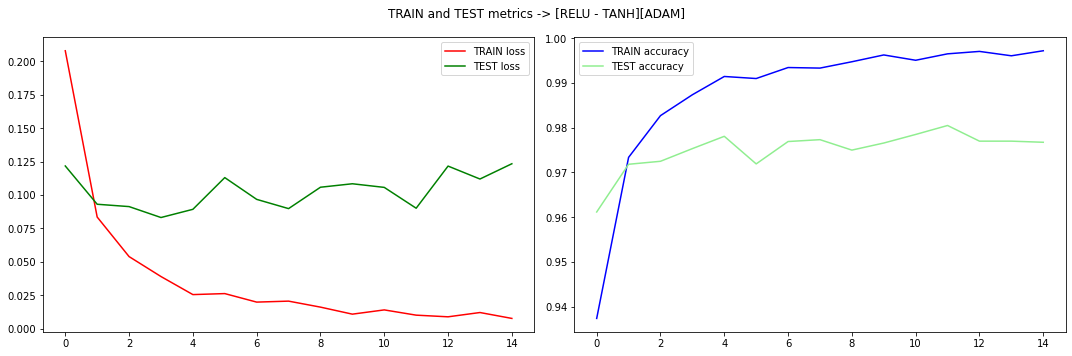

In [73]:
classic_adam = build_model(["relu", "tanh"], tf.keras.optimizers.Adam(learning_rate=learning_rate))
result = classic_adam.fit(X_train,
                          y_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          verbose=False)
plot_learning_metrics(result, "[RELU - TANH][ADAM]")

Accuracy: 99.577% 



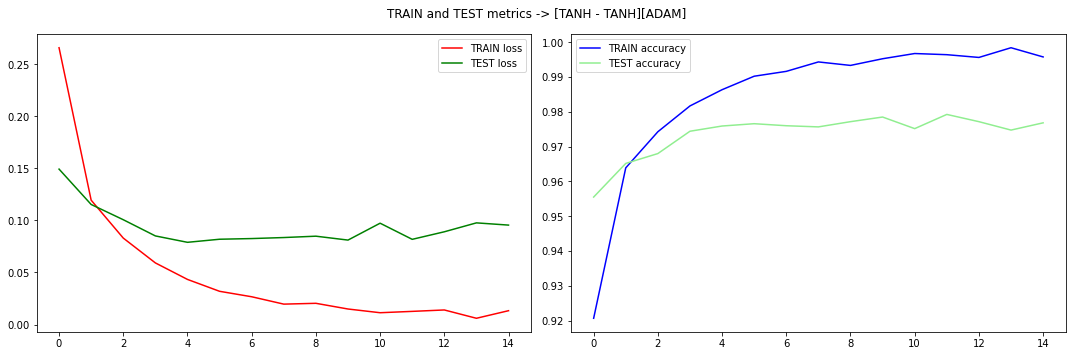

In [74]:
classic_adam = build_model(["tanh", "tanh"], tf.keras.optimizers.Adam(learning_rate=learning_rate))
result = classic_adam.fit(X_train,
                          y_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          verbose=False)
plot_learning_metrics(result, "[TANH - TANH][ADAM]")

Accuracy: 99.698% 



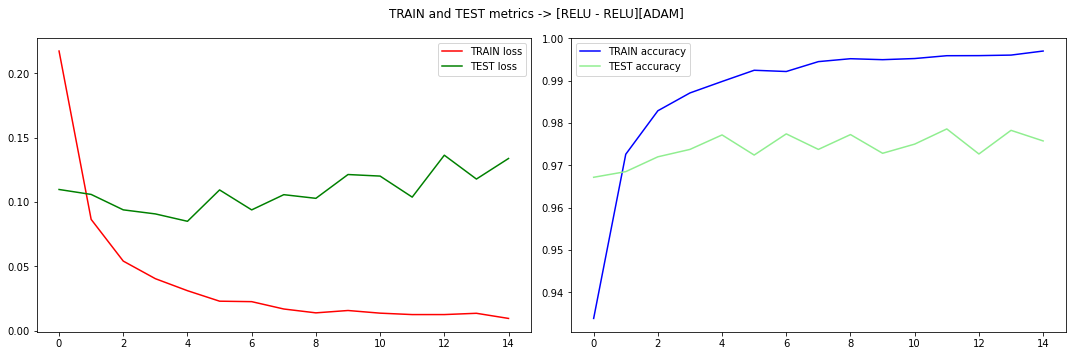

In [75]:
classic_adam = build_model(["relu", "relu"], tf.keras.optimizers.Adam(learning_rate=learning_rate))
result = classic_adam.fit(X_train,
                          y_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          verbose=False)
plot_learning_metrics(result, "[RELU - RELU][ADAM]")

<table>
    <tr>
        <td>layers activation</td>
        <td>Accuracy w/o Adam</td>
        <td>Accuracy with Adam</td>
    </tr>
    <tr>
        <td>ReLU - TANH</td>
        <td>89.65%</td>
        <td>99.72%</td>
    </tr>
    <tr>
        <td>TANH - TANH</td>
        <td>89.58%</td>
        <td>99.57%</td>
    </tr>
    <tr>
        <td>ReLU - ReLU</td>
        <td>89.97%</td>
        <td>99.69%</td>
    </tr>
</table>

#### Minibatch normalization

In [119]:
def build_model_with_batch_normalization1(learning_rate=0.0001):
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", input_shape=(array_size,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [120]:
model = build_model_with_batch_normalization1()
result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)

On TEST accuracy: 0.9732999801635742, auc: 0.9971224665641785
AUC on TEST: 0.9971224665641785
Accuracy: 99.819% 



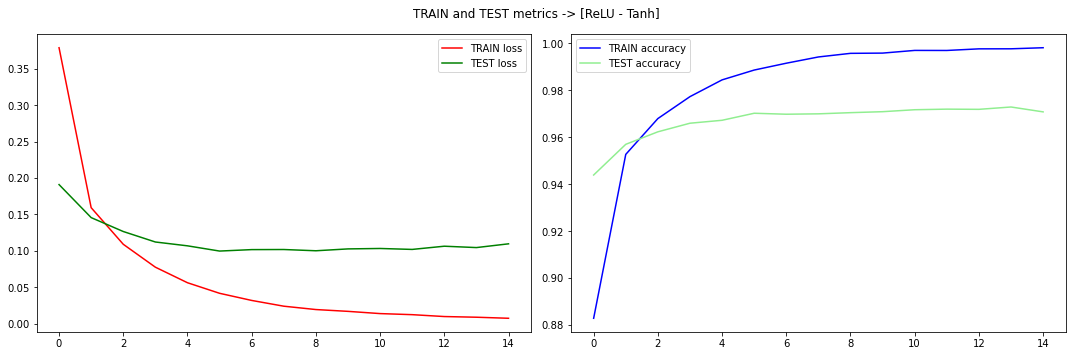

In [121]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "[ReLU - Tanh]")

In [94]:
def build_model_with_batch_normalization2(learning_rate=0.0001):
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), input_shape=(array_size,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

On TEST accuracy: 0.9606999754905701, auc: 0.9965532422065735
AUC on TEST: 0.9965532422065735
Accuracy: 98.308% 



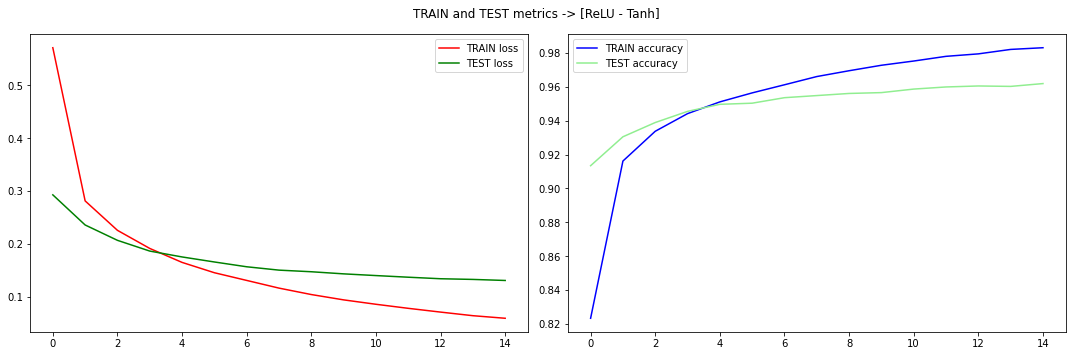

In [95]:
model = build_model_with_batch_normalization2()
result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)

_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print(f"On TEST accuracy: {accuracy}, auc: {auc}")
print(f"AUC on TEST: {auc}")

plot_learning_metrics(result, "[ReLU - Tanh]")

In [96]:
model_count_time(build_model_with_batch_normalization1(), (X_train, y_train), (X_test, y_test))
model_count_time(build_model_with_batch_normalization2(), (X_train, y_train), (X_test, y_test))

Learning time: 43.6347291469574
Prediction time: 0.32223033905029297
Train accuracy: 99.825%, test accuracy 97.15%
Learning time: 43.9541437625885
Prediction time: 0.31875157356262207
Train accuracy: 98.387%, test accuracy 95.99%


#### Dropout usage

In [97]:
def model_with_dropout(learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation="relu", input_shape=(array_size,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="tanh"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [98]:
model_with_dropout = model_with_dropout()
result = model_with_dropout.fit(X_train, 
                                y_train, 
                                epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                validation_split=0.2, 
                                verbose=False)

In [99]:
_, accuracy, auc = model_with_dropout.evaluate(X_test, y_test, verbose=False)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')
print(f'Test AUC: {np.round(100 * auc, 3)}%')

Test accuracy: 90.68%
Test AUC: 99.253%


Accuracy: 88.317% 



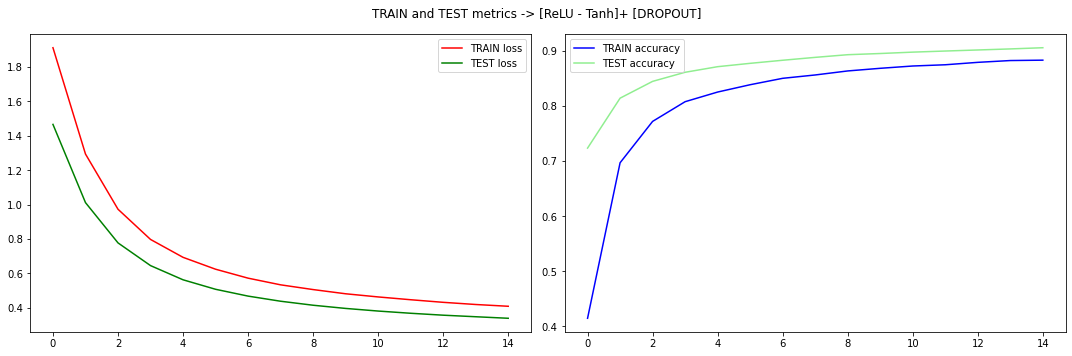

In [102]:
plot_learning_metrics(result, "[ReLU - Tanh]+ [DROPOUT]")

#### Early stopping implementation

In [103]:
def model_with_early_stopping(learning_rate=0.001):
    model = multi_layer_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=1)
    
    return model, callback

In [109]:
model, callback = model_with_early_stopping()
result = model.fit(X_train, 
          y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_split=0.2, 
          verbose=2, 
          callbacks=[callback])

Epoch 1/15
750/750 - 2s - loss: 1.9915 - accuracy: 0.4154 - auc_60: 0.7918 - val_loss: 1.6291 - val_accuracy: 0.6771 - val_auc_60: 0.9400 - 2s/epoch - 2ms/step
Epoch 2/15
750/750 - 1s - loss: 1.3821 - accuracy: 0.7316 - auc_60: 0.9555 - val_loss: 1.1256 - val_accuracy: 0.7913 - val_auc_60: 0.9722 - 1s/epoch - 2ms/step
Epoch 3/15
750/750 - 1s - loss: 1.0044 - accuracy: 0.7944 - auc_60: 0.9732 - val_loss: 0.8468 - val_accuracy: 0.8305 - val_auc_60: 0.9804 - 1s/epoch - 2ms/step
Epoch 4/15
750/750 - 1s - loss: 0.7997 - accuracy: 0.8223 - auc_60: 0.9795 - val_loss: 0.6940 - val_accuracy: 0.8526 - val_auc_60: 0.9844 - 1s/epoch - 1ms/step
Epoch 5/15
750/750 - 1s - loss: 0.6815 - accuracy: 0.8404 - auc_60: 0.9829 - val_loss: 0.6011 - val_accuracy: 0.8643 - val_auc_60: 0.9865 - 1s/epoch - 2ms/step
Epoch 6/15
750/750 - 1s - loss: 0.6053 - accuracy: 0.8521 - auc_60: 0.9850 - val_loss: 0.5393 - val_accuracy: 0.8726 - val_auc_60: 0.9880 - 1s/epoch - 1ms/step
Epoch 7/15
750/750 - 1s - loss: 0.5521 -

In [110]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose = False)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')
print(f'Test AUC: {np.round(100 * auc, 3)}%')

Test accuracy: 90.33%
Test AUC: 99.187%


Accuracy: 89.533% 



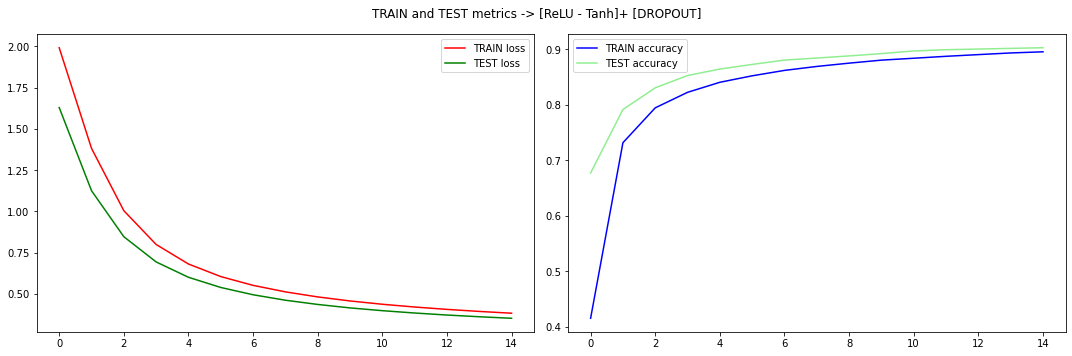

In [111]:
plot_learning_metrics(result, "[ReLU - Tanh]+ [DROPOUT]")

#### L-1 L-2 regularization

In [112]:
def model_regularization(learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l1", input_shape=(array_size,)),
        tf.keras.layers.Dense(256, activation="tanh", kernel_regularizer="l2"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
                metrics=["accuracy", tf.keras.metrics.AUC()])
    
    return model

In [113]:
model = model_regularization()
result = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.2, 
                    verbose=False)

In [114]:
_, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)

print(f'Test accuracy: {np.round(100 * accuracy, 3)}%')
print(f'Test AUC: {np.round(100 * auc, 3)}%')

Test accuracy: 79.03%
Test AUC: 97.151%


Accuracy: 77.671% 



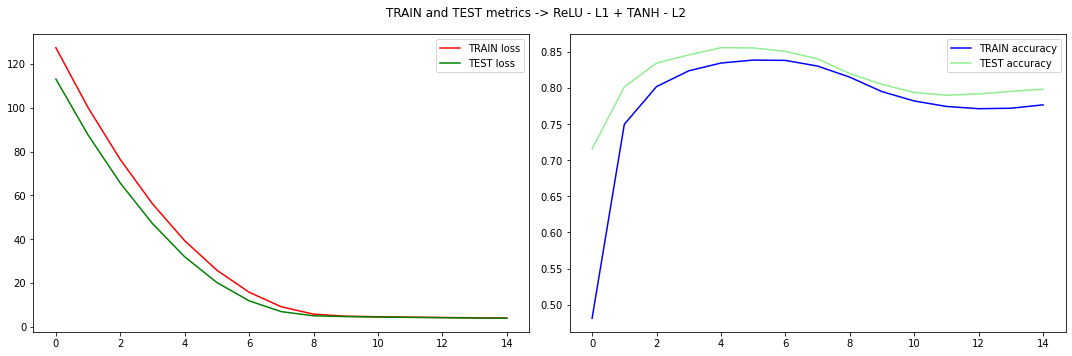

In [115]:
plot_learning_metrics(result, "ReLU - L1 + TANH - L2")

The best is model ReLU -> Tanh -> softmax that uses activation pf leaky RElu with $\alpha = 0.001$.
Accuracy is 98.3%

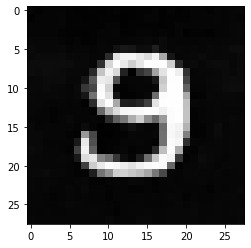

In [205]:
import cv2

digit = cv2.imread("./digit.jpg", cv2.IMREAD_GRAYSCALE)
digit = cv2.resize(digit, (28, 28), interpolation = cv2.INTER_AREA)
digit = cv2.bitwise_not(digit)

plt.imshow(digit, cmap="gray")
plt.show()

In [206]:
digit.shape

(28, 28)

In [201]:
array_size = digit.shape[0] * digit.shape[1]
model = build_generic_activation(tf.keras.layers.LeakyReLU(alpha=0.001), learning_rate)

result = model.fit(
    X_train,
    y_train, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=False
)

Hmmm.... What a number It could be 🤔

In [210]:
vectorized_digit = digit.reshape(array_size, 1) / 255.

pred = model.predict(np.expand_dims(vectorized_digit, axis=0))
print(f'predicted label: {np.where(np.round(pred[0]) == 1)[0][0]}')

predicted label: 9
